# Notebook for figures in Lakshmikanth et al - Immune system adaptation during female-to-male sex-reassignment

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import scipy
from scipy import sparse
import os
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from adjustText import adjust_text

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Specify adata_paths here

In [3]:
r848_v1_path = 'anndata_folder_scRNAseq/R848V1.h5ad' #
r848_v2_path = 'anndata_folder_scRNAseq/R848V2.h5ad'#

ntc_v1_path = 'anndata_folder_scRNAseq/NTCV1.h5ad'#
ntc_v2_path = 'anndata_folder_scRNAseq/NTCV2.h5ad'#

lps_v1_path = 'anndata_folder_scRNAseq/LPSV1.h5ad'#
lps_v2_path = 'anndata_folder_scRNAseq/LPSV2.h5ad'#

# Extended Figure 2b - pDC Barplots

In [3]:
r8_v1 = sc.read_h5ad(r848_v1_path)
r8_v2 = sc.read_h5ad(r848_v2_path)

In [4]:
#Get only pDCs from R848-stimulated cells
ct = 'pDC'
stim_v1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
stim_v2 = r8_v2[r8_v2.obs.celltype == ct].to_df()


In [7]:
#Comparing genes only found in both samples
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

### Creating inhouse btms

In [8]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]


In [9]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

In [10]:
inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})


In [11]:
btm = pd.read_csv('btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]

In [12]:
btm_append = btm.append(inhouse_btms)

In [13]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTM-sum
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = genes_included.append(pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0]))
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [14]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

In [15]:
btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

In [16]:
df_btm_v1 = pd.DataFrame({'module':btms_v1.module, 'stim_values':btms_v1['sum']})
df_btm_v2 = pd.DataFrame({'module':btms_v2.module, 'stim_values':btms_v2['sum']})

In [17]:
df_btm_v1['V'] = 'V1'
df_btm_v2['V'] = 'V2'

In [18]:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

In [19]:
modules = ['M5.0', 'M11.0', 'M71', 'M75', 'M111.1', 'M121', 'M127', 'M146', 'S5', 'Hallmark IFNa', 'Hallmark TNF']
barplot_df = barplot_df[barplot_df.module.isin(modules)]

Text(0.5, 1.0, 'pDC - R848 V1 and V2')

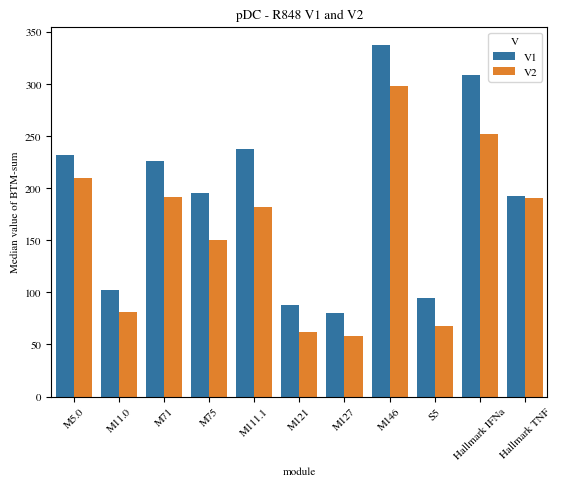

In [70]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(x = 'module', y = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45, )
plt.ylabel('Median value of BTM-sum')
plt.title('pDC - R848 V1 and V2')

# Extended Figure 2c - MX1

In [3]:
r8_v1 = sc.read_h5ad(r848_v1_path)
r8_v2 = sc.read_h5ad(r848_v2_path)
ct = 'pDC'
pdc_r848v1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
pdc_r848v2 = r8_v2[r8_v2.obs.celltype == ct].to_df()


In [4]:
lowIRF7v1 = pdc_r848v1[pdc_r848v1['IRF7'] < np.median(pdc_r848v1['IRF7'])]
highIRF7v1 = pdc_r848v1[pdc_r848v1['IRF7'] >= np.median(pdc_r848v1['IRF7'])]

lowIRF7v2 = pdc_r848v2[pdc_r848v2['IRF7'] < np.median(pdc_r848v2['IRF7'])]
highIRF7v2 = pdc_r848v2[pdc_r848v2['IRF7'] >= np.median(pdc_r848v2['IRF7'])]

In [5]:
highIRF7v1 = pd.DataFrame(highIRF7v1['MX1']).melt()
highIRF7v1['IRF7'] = 'high'

lowIRF7v1 = pd.DataFrame(lowIRF7v1['MX1']).melt()
lowIRF7v1['IRF7'] = 'low'

irf7v1 = pd.concat([lowIRF7v1, highIRF7v1])
irf7v1 = irf7v1.rename(columns = {'variable': 'gene'})

In [6]:
highIRF7v2 = pd.DataFrame(highIRF7v2['MX1']).melt()
highIRF7v2['IRF7'] = 'high'

lowIRF7v2 = pd.DataFrame(lowIRF7v2['MX1']).melt()
lowIRF7v2['IRF7'] = 'low'

irf7v2 = pd.concat([lowIRF7v2, highIRF7v2])
irf7v2 = irf7v2.rename(columns = {'variable': 'gene'})

Text(1085.0378787878785, 0.5, 'Genecount')

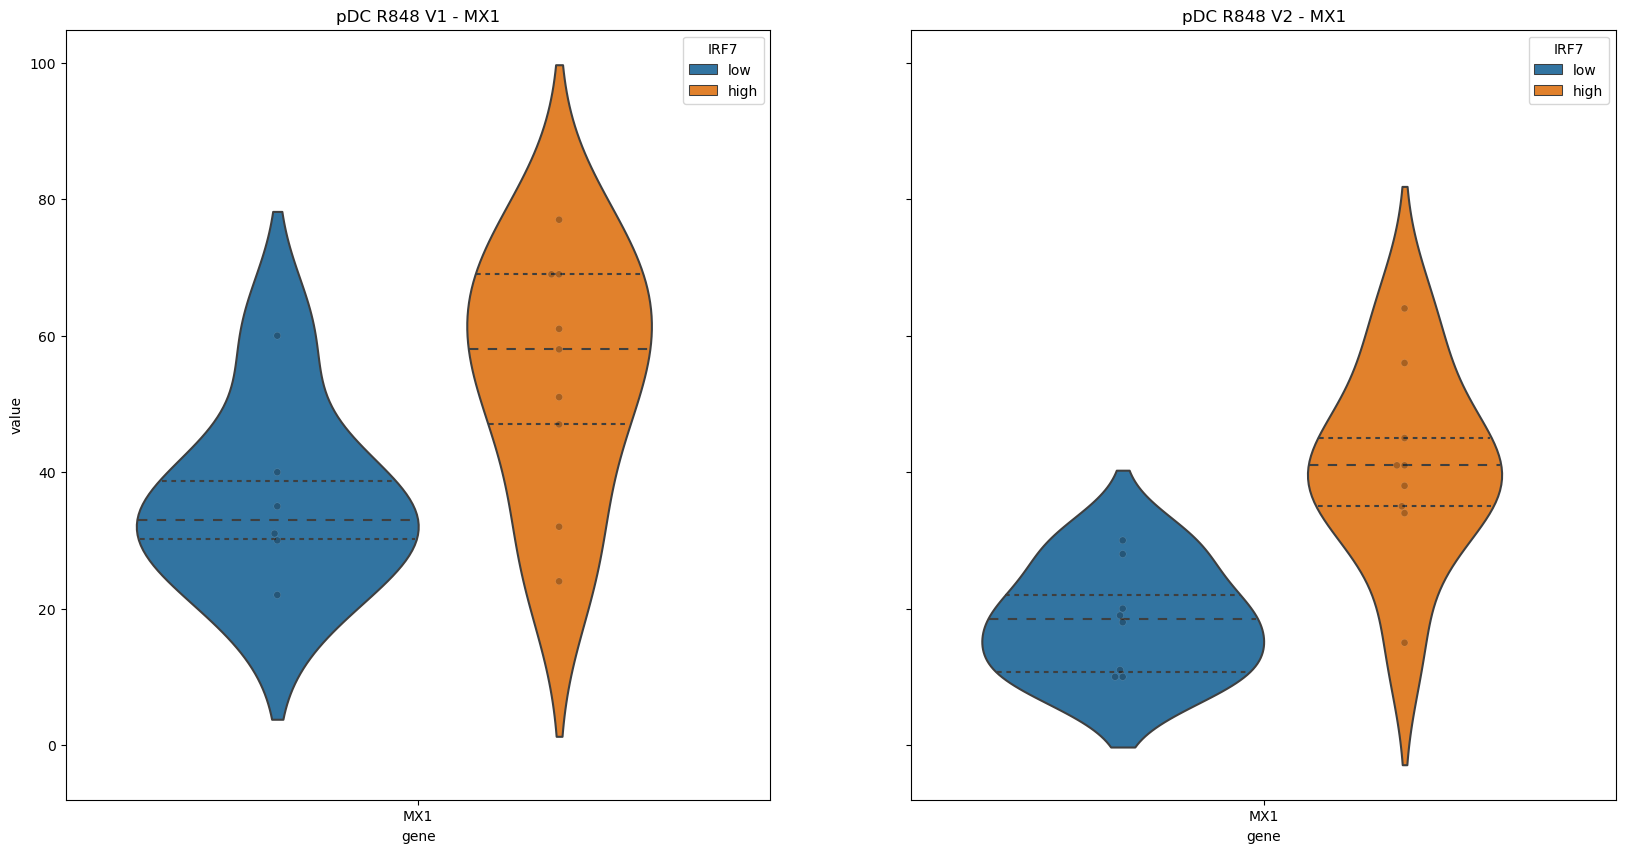

In [7]:
fig, ax = plt.subplots(1,2, figsize = (20,10), sharey = True)
sns.swarmplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v1, dodge = True, edgecolor = 'white', linewidth = 0.25, alpha = 0.25, palette = ['black', 'black'], legend = False, ax = ax[0])
sns.violinplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v1, inner = 'quartile', ax = ax[0])

sns.swarmplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v2, dodge = True, edgecolor = 'white', linewidth = 0.25, alpha = 0.25, palette = ['black', 'black'], legend = False, ax = ax[1])
sns.violinplot(x = 'gene', y = 'value', hue = 'IRF7', data = irf7v2, inner = 'quartile', ax = ax[1])

ax[0].set_title('pDC R848 V1 - MX1')
ax[1].set_title('pDC R848 V2 - MX1')
plt.ylabel('Genecount')

# Extended data Figure 3c - Monocyte R848 barplot

In [3]:
r8_v1 = sc.read_h5ad(r848_v1_path)
r8_v2 = sc.read_h5ad(r848_v2_path)
ct = 'Monocyte'
stim_v1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
stim_v2 = r8_v2[r8_v2.obs.celltype == ct].to_df()


In [6]:
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [7]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]


In [8]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

In [9]:
inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})


In [10]:
btm = pd.read_csv('btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]

In [11]:
btm_append = btm.append(inhouse_btms)

In [12]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTMs
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = genes_included.append(pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0]))
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [13]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

In [14]:
btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

In [15]:
df_btm_v1 = pd.DataFrame({'module':btms_v1.module, 'stim_values':btms_v1['sum']})
df_btm_v2 = pd.DataFrame({'module':btms_v2.module, 'stim_values':btms_v2['sum']})

In [16]:
df_btm_v1['V'] = 'V1'
df_btm_v2['V'] = 'V2'

In [17]:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

In [18]:
modules_r848 = ['M13', 'M27.0', 'M29', 'M43.0', 'M86.1', 'M127', 'M165', 'Hallmark IFNa', 'Hallmark TNF']

barplot_df = barplot_df[barplot_df.module.isin(modules_r848)]

Text(0.5, 1.0, 'Monocyte - R848 V1 and V2')

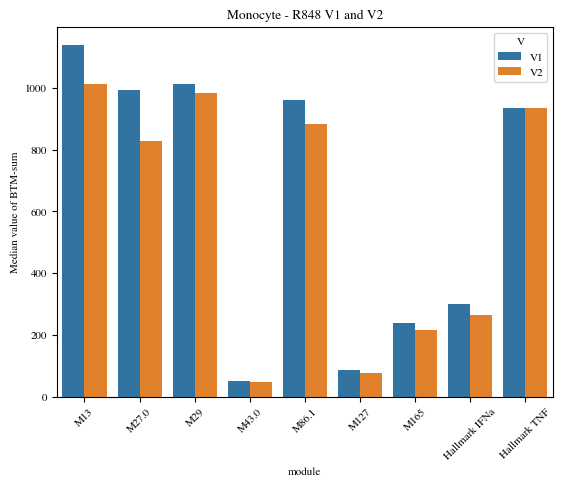

In [78]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(x = 'module', y = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45, )
plt.ylabel('Median value of BTM-sum')
plt.title('Monocyte - R848 V1 and V2')


# Extended Data Figure 4 c,d,e - Th1,2,17 markers

In [3]:
ntc_v1 = sc.read_h5ad(ntc_v1_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)


In [4]:
th1_markers = ['TNF',
 'IFNG',
 'EGR2',
 'CCL4L2',
 'F2R',
 'APOBEC3G',
 'FASLG',
 'IL2',
 'CCL4',
 'CCL5',
 'AOAH',
 'GZMA',
 'GZMB',
 'TBX21',
 'GZMK',
 'ALDOC']

In [5]:
th2_markers = [
 'PLIN2',
 'CD83',
 'NFKBIZ',
 'NFKBID',
 'CCR4',
 'GATA3',
 'PPARG',
 'LIF',
 'IL9R',
 'BCAR3',
 'C1orf162',
 'CHDH',
 'GPR35',
 'NENF',
 'PDLIM5',
 'PLN']

In [6]:
th17_markers = [
 'ABCB1',
 'THBS1',
 'TRBV18',
 'TRAV13-2',
 'PTPN22',
 'RUNX2',
 'IL18RAP',
 'IL23R',
 'GPR65',
 'MGAT4A',
 'TMIGD2']

In [7]:
cd4t_v1 = ntc_v1[ntc_v1.obs.celltype == 'CD4T'].copy().to_df()
cd4t_v2 = ntc_v2[ntc_v2.obs.celltype == 'CD4T'].copy().to_df()

In [8]:
markers = th1_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th1_df = pd.concat([v1,v2])

markers = th2_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th2_df = pd.concat([v1,v2])

markers = th17_markers
v1 = pd.melt(cd4t_v1[markers])
v2 = pd.melt(cd4t_v2[markers])
v1['V'] = 'V1'
v2['V'] = 'V2'
th17_df = pd.concat([v1,v2])




Text(0.5, 58.7222222222222, '')

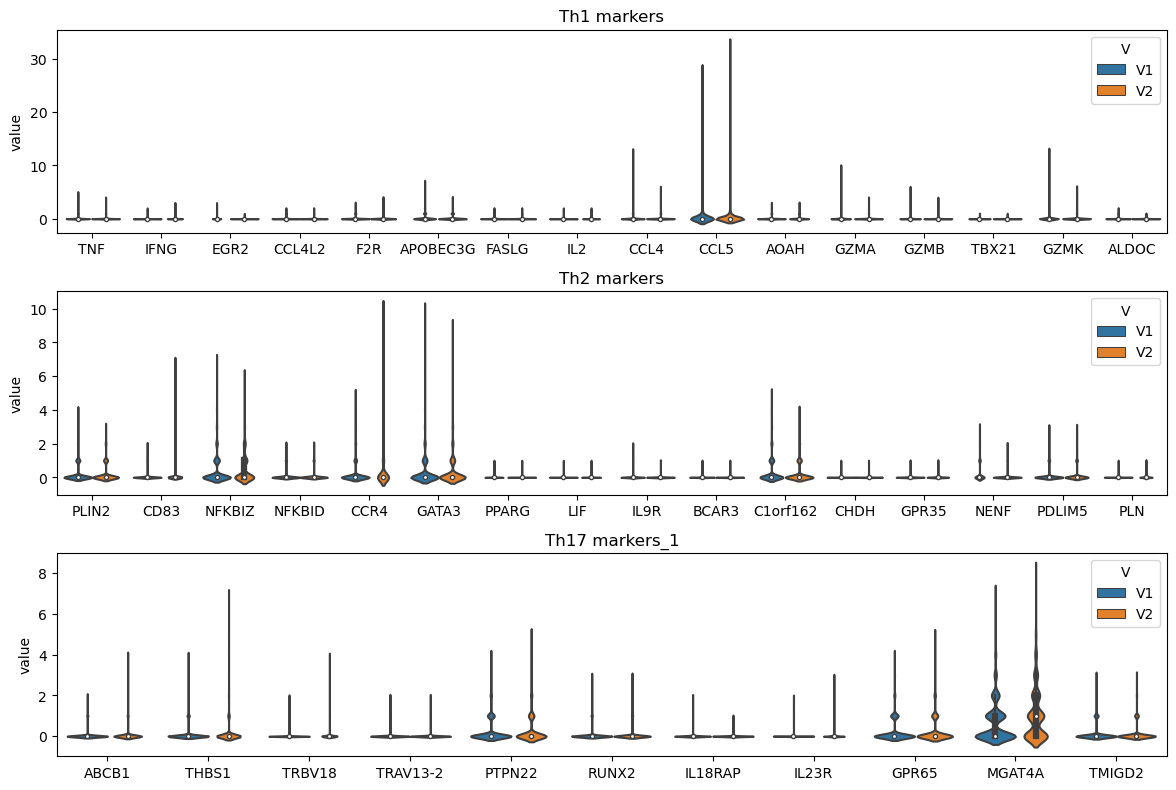

In [9]:
fig, ax = plt.subplots(3,1, figsize = (12,8))
sns.violinplot(data = th1_df, x = 'variable', y = 'value', hue = 'V', ax = ax[0])
sns.violinplot(data = th2_df, x = 'variable', y = 'value', hue = 'V', ax = ax[1])
sns.violinplot(data = th17_df, x = 'variable', y = 'value', hue = 'V', ax = ax[2])

plt.tight_layout()
ax[0].set_title('Th1 markers')
ax[1].set_title('Th2 markers')
ax[2].set_title('Th17 markers_1')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')


# Figure 2g - pDC Hallmark IFNa genes

In [22]:
r8_v1 = sc.read_h5ad(r848_v1_path)
ntc_v1 = sc.read_h5ad(ntc_v1_path)

r8_v2 = sc.read_h5ad(r848_v2_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)

In [23]:
ct = 'pDC'
countv1 = r8_v1[r8_v1.obs.celltype == ct].to_df() 
countv2 = r8_v2[r8_v2.obs.celltype == ct].to_df() 


notstim_v1 = ntc_v1[ntc_v1.obs.celltype == ct].to_df()
notstim_v2 = ntc_v2[ntc_v2.obs.celltype == ct].to_df()


In [24]:
countv1 = countv1.groupby(axis=1, level=0).sum()
countv2 = countv2.groupby(axis=1, level=0).sum()
countv1 = countv1[countv1.columns[countv1.columns.isin(countv2.columns)]]
countv2 = countv2[countv2.columns[countv2.columns.isin(countv1.columns)]]

In [25]:
ntcmedian_v1 = notstim_v1.median()
ntcmedian_v2 = notstim_v2.median()

ntcmedian_v1 = ntcmedian_v1[ntcmedian_v1.index.isin(countv1.columns)]
ntcmedian_v2 = ntcmedian_v2[ntcmedian_v2.index.isin(countv2.columns)]


In [26]:
countv2_sub = countv2.copy(deep = True)
countv1_sub = countv1.copy(deep = True)

In [27]:
countv1_sub = countv1_sub[ntcmedian_v1.index]
countv2_sub = countv2_sub[ntcmedian_v2.index]

In [28]:
#Normalizing by subtracting median sum
countv1_sub = countv1_sub - ntcmedian_v1
countv2_sub = countv2_sub - ntcmedian_v2

In [29]:
markers = ['ISG20', 'MX1', 'PARP14', 'SP110']

In [30]:
countv2_sub = countv2_sub.fillna(0)
countv1_sub = countv1_sub.fillna(0)

In [31]:
markersum_v1 = np.sum(countv1_sub[countv1_sub.columns[countv1_sub.columns.isin(markers)]])

In [32]:
markersum_v2 = np.sum(countv2_sub[countv2_sub.columns[countv2_sub.columns.isin(markers)]])

In [33]:
markers

['ISG20', 'MX1', 'PARP14', 'SP110']

In [34]:
violin_df = pd.DataFrame()
for m in markers:
    temp1 = pd.DataFrame({'value': countv1_sub[m], 'gene':m, 'V':'V1'})
    temp2 = pd.DataFrame({'value': countv2_sub[m], 'gene':m, 'V':'V2'})
    both = pd.concat([temp1, temp2])
    violin_df = pd.concat([both, violin_df])

<AxesSubplot: xlabel='gene', ylabel='value'>

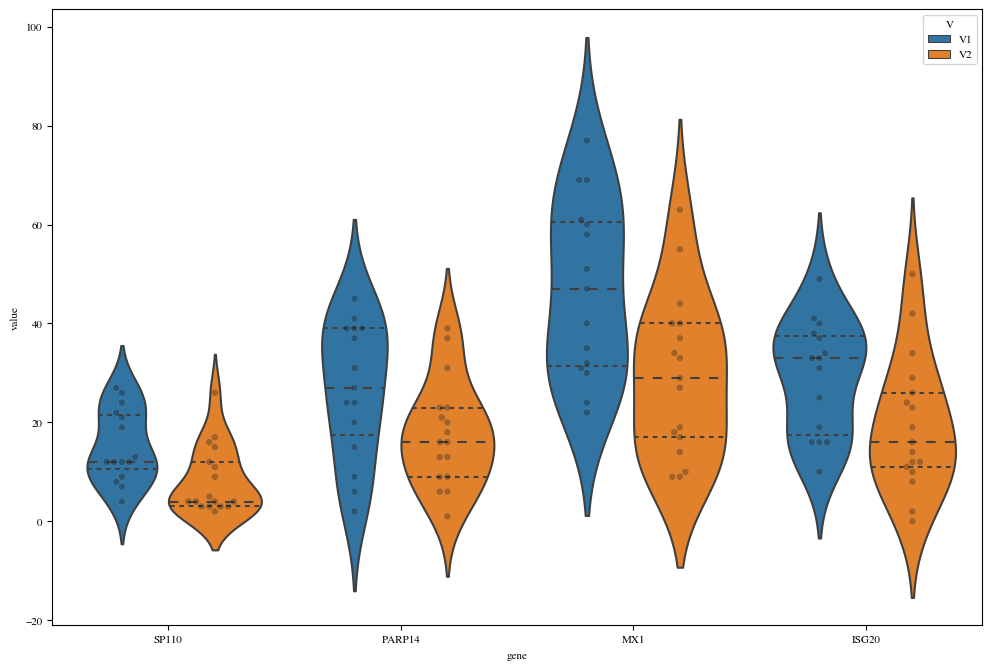

In [37]:
plt.figure(figsize = (12,8))
sns.swarmplot(x = 'gene', y = 'value', hue = 'V', data = violin_df, dodge = True, edgecolor = 'white', linewidth = 0.25, alpha = 0.25, palette = ['black', 'black'], legend = False)
sns.violinplot(x = 'gene', y = 'value', hue = 'V', data = violin_df, inner = 'quartile')



# Figure 3c - Monocytes - Barplots

In [4]:
lps_v1 = sc.read_h5ad(lps_v1_path)
lps_v2 = sc.read_h5ad(lps_v2_path)

In [5]:
ct = 'Monocyte'
stim_v1 = lps_v1[lps_v1.obs.celltype == ct].to_df()
stim_v2 = lps_v2[lps_v2.obs.celltype == ct].to_df() 


In [8]:
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [9]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]


In [10]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

In [11]:
inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})


In [12]:
btm = pd.read_csv('btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]

In [13]:
btm_append = btm.append(inhouse_btms)

In [14]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTMs
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = genes_included.append(pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0]))
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [15]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

In [16]:
btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

In [17]:
df_btm_v1 = pd.DataFrame({'module':btms_v1.module, 'stim_values':btms_v1['sum']})
df_btm_v2 = pd.DataFrame({'module':btms_v2.module, 'stim_values':btms_v2['sum']})

In [18]:
df_btm_v1['V'] = 'V1'
df_btm_v2['V'] = 'V2'

In [19]:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

In [20]:
modules_lps = ['M13', 'M27.0', 'M29', 'M43.0', 'M86.1', 'M127', 'M165', 'Hallmark IFNa', 'Hallmark TNF']
barplot_df = barplot_df[barplot_df.module.isin(modules_lps)]

Text(0.5, 1.0, 'Monocyte - LPS V1 and V2')

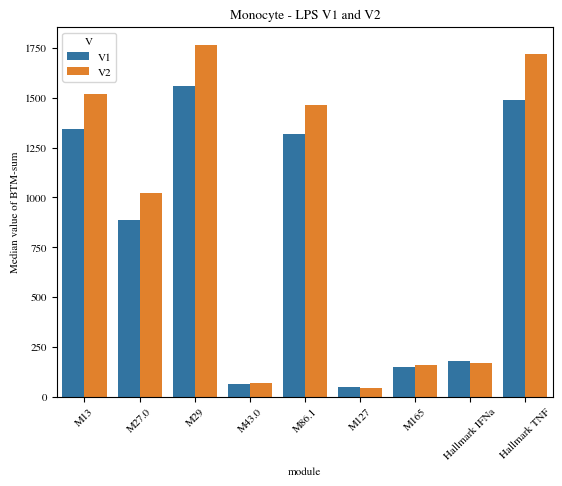

In [20]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(x = 'module', y = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45, )
plt.ylabel('Median value of BTM-sum')
plt.title('Monocyte - LPS V1 and V2')


## T-test for monocyte barplots

In [21]:
#markers = []
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Summarize BTMs for all cells
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1).values})
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
        


In [22]:
btms_v1 = dfs_btm[0]
btms_v2 = dfs_btm[1]

In [23]:
monos_lps_t_test = pd.DataFrame()
for m in modules_lps:
    t_statistic, pvalue = stats.ttest_ind(a=btms_v1[m], b=btms_v2[m] )
    temp = pd.DataFrame({'t_statistc': t_statistic, 'pvalue':pvalue}, index=[m])
    monos_lps_t_test = pd.concat([monos_lps_t_test, temp])

In [24]:
monos_lps_t_test

,t_statistc,pvalue
M13,-3.138497,0.001755
M27.0,-3.016339,0.002633
M29,-3.639858,0.000289
M43.0,-0.367090,0.713641
M86.1,-2.510310,0.012243
M127,2.293666,0.022047
M165,-1.682799,0.092772
Hallmark IFNa,2.736974,0.006327
Hallmark TNF,-4.177678,0.000032


In [25]:
p_adjusted = multipletests(monos_lps_t_test['pvalue'], method='bonferroni')
monos_lps_t_test['p_adjusted'] = p_adjusted[1]

In [26]:
monos_lps_t_test

,t_statistc,pvalue,p_adjusted
M13,-3.138497,0.001755,0.015798
M27.0,-3.016339,0.002633,0.023695
M29,-3.639858,0.000289,0.002600
M43.0,-0.367090,0.713641,1.000000
M86.1,-2.510310,0.012243,0.110185
M127,2.293666,0.022047,0.198423
M165,-1.682799,0.092772,0.834951
Hallmark IFNa,2.736974,0.006327,0.056943
Hallmark TNF,-4.177678,0.000032,0.000292


# Figure 3B - Monocytes - genes

In [21]:
lps_v1 = sc.read_h5ad(lps_v1_path)
lps_v2 = sc.read_h5ad(lps_v2_path)

ntc_v1 = sc.read_h5ad(ntc_v1_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)



In [22]:
ct = 'Monocyte'
countv1 = lps_v1[lps_v1.obs.celltype == ct].to_df() 
countv2 = lps_v2[lps_v2.obs.celltype == ct].to_df() 


notstim_v1 = ntc_v1[ntc_v1.obs.celltype == ct].to_df()
notstim_v2 = ntc_v2[ntc_v2.obs.celltype == ct].to_df()


In [23]:
countv1 = countv1[countv1.columns[countv1.columns.isin(countv2.columns)]]
countv2 = countv2[countv2.columns[countv2.columns.isin(countv1.columns)]]

In [24]:
ntcmedian_v1 = notstim_v1.median()
ntcmedian_v2 = notstim_v2.median()

ntcmedian_v1 = ntcmedian_v1[ntcmedian_v1.index.isin(countv1.columns)]
ntcmedian_v2 = ntcmedian_v2[ntcmedian_v2.index.isin(countv2.columns)]


In [25]:
countv2_sub = countv2.copy(deep = True)
countv1_sub = countv1.copy(deep = True)

In [26]:
countv1_sub = countv1_sub[ntcmedian_v1.index]
countv2_sub = countv2_sub[ntcmedian_v2.index]

In [27]:
#Normalizing by subtracting median sum
countv1_sub = countv1_sub - ntcmedian_v1
countv2_sub = countv2_sub - ntcmedian_v2

In [28]:
markers = ['TNF', 'CXCL2', 'SERPINB2', 'CD44', 'CCL20', 'SOCS3', 'IL6','IL1B', 'IL1A','F3']

In [29]:
countv2_sub = countv2_sub.fillna(0)
countv1_sub = countv1_sub.fillna(0)

In [30]:
markersum_v1 = np.sum(countv1_sub[countv1_sub.columns[countv1_sub.columns.isin(markers)]])

In [31]:
markersum_v2 = np.sum(countv2_sub[countv2_sub.columns[countv2_sub.columns.isin(markers)]])

In [32]:
markers

['TNF',
 'CXCL2',
 'SERPINB2',
 'CD44',
 'CCL20',
 'SOCS3',
 'IL6',
 'IL1B',
 'IL1A',
 'F3']

In [33]:
violin_df = pd.DataFrame()
for m in markers:
    temp1 = pd.DataFrame({'value': countv1_sub[m], 'gene':m, 'V':'V1'})
    temp2 = pd.DataFrame({'value': countv2_sub[m], 'gene':m, 'V':'V2'})
    both = pd.concat([temp1, temp2])
    violin_df = pd.concat([both, violin_df])

<AxesSubplot: xlabel='gene', ylabel='value'>

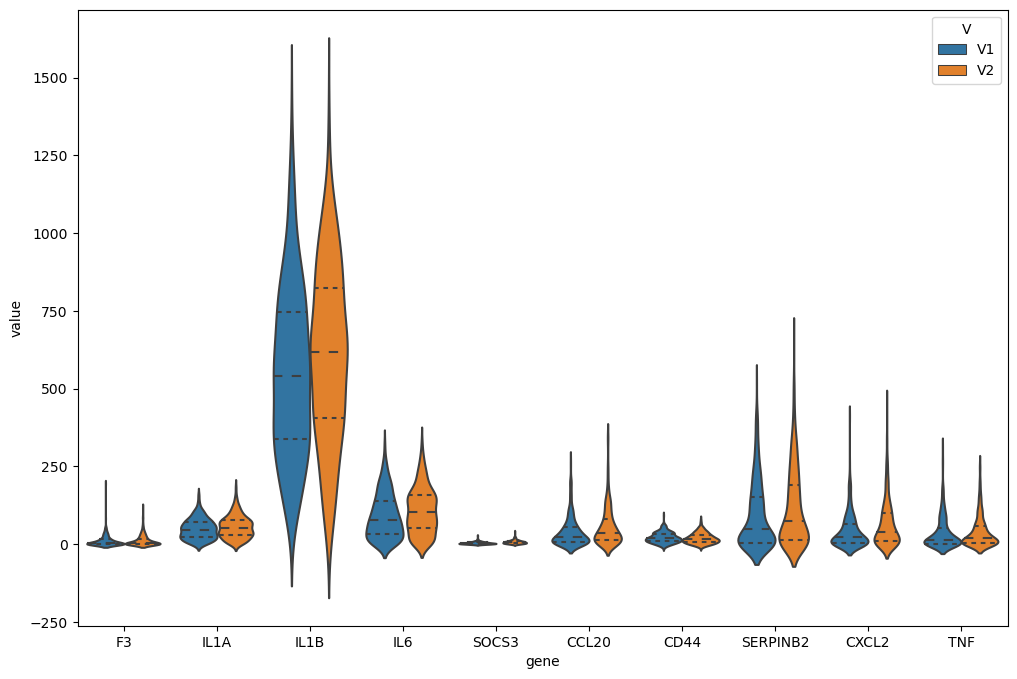

In [17]:

plt.figure(figsize = (12,8))
#sns.swarmplot(x = 'gene', y = 'value', hue = 'V', data = violin_df, dodge = True, edgecolor = 'white', linewidth = 0.25, alpha = 0.25, palette = ['black', 'black'], legend = False)
sns.violinplot(x = 'gene', y = 'value', hue = 'V', data = violin_df, inner = 'quartile')



# Preparing for NicheNet - for Figure 3e

In [49]:
lps_v1 = sc.read_h5ad(lps_v1_path)
lps_v2 = sc.read_h5ad(lps_v2_path)


In [47]:
lps_v1.obs['V'] = 'V1'
lps_v2.obs['V'] = 'V2'
lps_v1.var_names_make_unique()
lps_v2.var_names_make_unique()
lps_v1.obs_names_make_unique()
lps_v2.obs_names_make_unique()


add = ad.concat([lps_v1, lps_v2])


In [ ]:
sc.pp.normalize_total(add, target_sum = 10000)#and off to NicheNet we go

In [48]:
#add.write('insert pathway to store anndata here') 